### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Градиентный бустинг


**Общая информация**

**Срок сдачи:** 10 мая 2021, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 10 мая, -4 балла после 08:30 17 мая, -6 баллов после 08:30 24 мая, -8 баллов после 08:30 31 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0221, Задание 4] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

Ваше решение тут ($F$ считаем за $a(x_i)$):

1) MSE: $$-\frac{\partial L}{\partial F} = 2*(y_i -F(x_i))$$

2) Экспоненциональная: $$-\frac{\partial L}{\partial F} = y_i*exp(-F(x_i)*y_i)$$

3) Логистическая: $$-\frac{\partial L}{\partial F} = \frac{y_i*exp(-F(x_i)*y_i)}{1+exp(-F(x_i)*y_i)} = \frac{y_i}{exp(F(x_i)*y_i) + 1}$$

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [33]:
import numpy as np
import random

from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from tqdm.notebook import tqdm

In [51]:
class MyGradientBoostingClassifier:

    def __init__(self, loss = "mse", learning_rate = 0.01, n_estimators = 100,
                 colsample = 0.9, subsample = 0.9, *args, **kwargs):
        """
        loss -- один из 3 лоссов:
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучнеии одного алгоритма
        subsample -- процент рандомных объектов при обучнеии одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        # Ваш код здесь
        self.loss = loss
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.colsample = colsample
        self.subsample = subsample
        self.args = args
        self.kwargs = kwargs
        self.estimators = []
        self.features = []
        self.init_model = None
    
    def fit(self, X, y, base_model = DecisionTreeRegressor, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        # Ваш код здесь
        
        if (init_model is not None):
            clf = init_model()
            self.init_model = clf
            clf.fit(X, y)
            F = self.learning_rate * clf.predict(X)
        else:
            F = np.ones(X.shape[0]) * 0.2
    
        col_size = int(X.shape[1] * self.colsample)
        obj_size = int(X.shape[0] * self.subsample)
        
        for i in tqdm(range(self.n_estimators), leave=False):
            obj_indices = np.random.randint(0, X.shape[0], size = obj_size)
            col_indices = np.random.randint(0, X.shape[1], size = col_size)
    
            self.features.append(col_indices)
            X_train = X[obj_indices]
            y_train = y[obj_indices]
            X_part = X_train[:, col_indices]
            
            if (self.loss == "mse"):
                gradient = 2 * (y_train - F[obj_indices])
            elif(self.loss == "exp"):
                gradient = y_train * np.exp(- F[obj_indices] * y_train)
            elif(self.loss == "log"):
                gradient = y_train / (1 + np.exp(F[obj_indices] * y_train))
                
            clf = base_model(*self.args, **self.kwargs)
            clf.fit(X_part, gradient)
            self.estimators.append(clf)
            F += self.learning_rate * clf.predict(X[:, col_indices])


    def predict(self, X):
        # Ваш код здесь
        if (self.init_model is not None):
            pred = self.learning_rate * self.init_model.predict(X)
        else:
            pred = np.ones(X.shape[0]) * 0.2
        
        for i in tqdm(range(self.n_estimators), leave=False):
            pred += self.learning_rate * self.estimators[i].predict(X[:,
                                                      self.features[i]])
        return np.rint(pred).astype(int)


In [61]:
my_clf = MyGradientBoostingClassifier()
clf = GradientBoostingClassifier()

In [62]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [63]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
of_y_pred=clf.predict(X_test)
my_pred=my_clf.predict(X_test)

print(accuracy_score(y_pred=of_y_pred, y_true=y_test))
print(accuracy_score(y_pred=my_pred, y_true=y_test))
of_y_pred, my_pred

1.0
1.0


(array([1, 0, 1, 1, 2, 1, 1, 1, 2, 0, 1, 0, 0, 0, 2, 2, 2, 0]),
 array([1, 0, 1, 1, 2, 1, 1, 1, 2, 0, 1, 0, 0, 0, 2, 2, 2, 0]))

## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [64]:
from sklearn.datasets import fetch_california_housing
from sklearn import model_selection
import matplotlib.pyplot as plt

X, y = fetch_california_housing(return_X_y=True)

In [65]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape, y)

(20640, 8) (20640,) [1 1 1 ... 0 0 0]


In [66]:
estim_num = np.arange(1, 102)
accur_est = np.zeros(estim_num.shape[0])
for n_iter in tqdm(range(1, 102), leave = False):
    my_clf = MyGradientBoostingClassifier(n_estimators = n_iter)
    train_data, test_data, train_y, test_y = model_selection.train_test_split(X, y)
    my_clf.fit(train_data, train_y)
    my_pred = my_clf.predict(test_data)
    accur_est[n_iter - 1] = accuracy_score(y_pred=my_pred, y_true=test_y)
# accur_est

In [67]:
best_estim = np.argmax(accur_est) + 1
best_estim

91

Лучшее число итераций: 91, на нем достигается лучший скор: 0.894


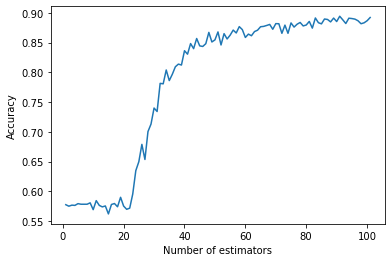

In [68]:
plt.xlabel("Number of estimators")
plt.ylabel("Accuracy")

plt.plot(estim_num, accur_est)
print("Лучшее число итераций: {0}, на нем достигается лучший скор: {1}".format(best_estim, 
                          float("{0:.3f}".format(np.max(accur_est)))))

In [69]:
accur_l = np.zeros(3)
losses = ["mse", "exp", "log"]
i = 0
for l in tqdm(losses, leave=False):
    my_clf = MyGradientBoostingClassifier(n_estimators = best_estim, 
                                          loss = l)
    train_data, test_data, train_y, test_y = model_selection.train_test_split(X, y)
    my_clf.fit(train_data, train_y)
    my_pred = my_clf.predict(test_data)
    accur_l[i] = accuracy_score(y_pred = my_pred, y_true = test_y)
    i += 1
accur_l

array([0.89050388, 0.88449612, 0.77713178])

In [70]:
best_loss = losses[np.argmax(accur_l)]
best_loss

'mse'

Лучший loss: mse, на нем достигается лучший скор: 0.891


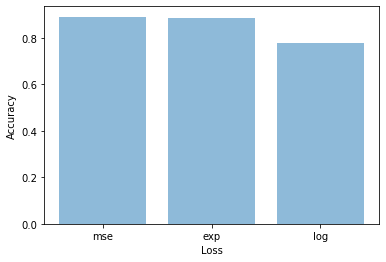

In [71]:
plt.xlabel("Loss")
plt.ylabel("Accuracy")

plt.bar(losses, accur_l, alpha=0.5)
print("Лучший loss: {0}, на нем достигается лучший скор: {1}".format(best_loss, 
                          float("{0:.3f}".format(np.max(accur_l)))))

## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

In [72]:
from sklearn.ensemble import RandomForestRegressor

train_data, test_data, train_y, test_y = model_selection.train_test_split(X, y)

my_clf = MyGradientBoostingClassifier(n_estimators = best_estim, loss = best_loss)
my_clf.fit(X_train, y_train, base_model = RandomForestRegressor)

accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

0.8888888888888888

In [73]:
def get_bootstrap_samples(data, y, n_samples):
    indices = np.random.randint(0, data.shape[0], size = n_samples)
    return data[indices], y[indices]

In [74]:
pred = np.zeros(test_data.shape[0])
for i in tqdm(range(10), leave=False):
    X_boot, y_boot = get_bootstrap_samples(train_data, train_y, train_data.shape[0] // 10)
    my_clf = MyGradientBoostingClassifier(n_estimators = best_estim, loss = best_loss)
    my_clf.fit(X_boot, y_boot)
    pred += my_clf.predict(test_data)

accuracy_score(y_pred = pred // 10, y_true=test_y)

0.8112403100775194

Итого вариант со случайным лесом дает сравнимые результаты, на втором же варианте скор сильно упал, возможно, потому что поданная ему выборка для бутстрапа не достаточна по объему\ не подходящие параметры.

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [75]:
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

In [76]:
train_data, test_data, train_y, test_y = model_selection.train_test_split(X, y)

In [77]:
my_clf = MyGradientBoostingClassifier(n_estimators = best_estim, loss = best_loss)
my_clf.fit(train_data, train_y, init_model = LinearRegression)

accur_lin = accuracy_score(test_y, my_clf.predict(test_data))

In [78]:
my_clf = MyGradientBoostingClassifier(n_estimators = best_estim, loss = best_loss)
my_clf.fit(train_data, train_y, init_model = SGDClassifier)

accur_sgd = accuracy_score(test_y, my_clf.predict(test_data))

In [79]:
my_clf = MyGradientBoostingClassifier(n_estimators = best_estim, loss = best_loss)
my_clf.fit(train_data, train_y, init_model = RandomForestRegressor)

accur_rf = accuracy_score(test_y, my_clf.predict(test_data))

In [80]:
my_clf = MyGradientBoostingClassifier(n_estimators = best_estim, loss = best_loss)
my_clf.fit(train_data, train_y, init_model = LinearSVC)

accur_svc = accuracy_score(test_y, my_clf.predict(test_data))

C:\Users\dashaz\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [81]:
my_clf = MyGradientBoostingClassifier(n_estimators = best_estim, loss = best_loss)
my_clf.fit(train_data, train_y, init_model = KNeighborsClassifier)

accur_knn = accuracy_score(test_y, my_clf.predict(test_data))

In [82]:
accur_lin, accur_sgd, accur_svc, accur_knn, accur_rf

(0.8846899224806202,
 0.8781007751937985,
 0.8825581395348837,
 0.887015503875969,
 0.8748062015503876)

Превзойти скор не получилось, начальная модель подбирается по данным, каждым данным - своя начальная. В данном случае все примерно на одном уровне остаются.

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.


### ВАШ ОТЗЫВ ЗДЕСЬ

